# Legal Intelligence Rank Monitor


<br>



This jupyter notebook provides the prototype of the rank monitor:

It should:

- Request queries, clicks and their corresponding position on the query list
- Pre-process the data into readable format
- Calculate the NDCG
- Be able to re-run queries, with appropriate access rights and re-calculate the nDCG

<br> 


### Basic Utilities for python

In [84]:
import numpy as np
from sklearn.metrics import f1_score, average_precision_score
import math
import requests
import os

import datetime
from datetimerange import DateTimeRange
from datetime import timedelta  
from dateutil import parser
from urllib import *
import json

from pathlib import Path
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from collections import Counter
from tqdm import tqdm_notebook 
tqdm_notebook().pandas()
from tqdm import tqdm_notebook as tqdm

from time import strftime, gmtime
import pathlib

import requests


# Greedy IDE completion 
%config IPCompleter.greedy=True

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; } </style>"))
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 11)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"




HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [85]:
# Activate Jupyter %%javascript magic
%lsmagic

Available line magics:
%alias  %alias_magic  %autocall  %automagic  %autosave  %bookmark  %cat  %cd  %clear  %colors  %config  %connect_info  %cp  %debug  %dhist  %dirs  %doctest_mode  %ed  %edit  %env  %gui  %hist  %history  %killbgscripts  %ldir  %less  %lf  %lk  %ll  %load  %load_ext  %loadpy  %logoff  %logon  %logstart  %logstate  %logstop  %ls  %lsmagic  %lx  %macro  %magic  %man  %matplotlib  %mkdir  %more  %mv  %notebook  %page  %pastebin  %pdb  %pdef  %pdoc  %pfile  %pinfo  %pinfo2  %popd  %pprint  %precision  %profile  %prun  %psearch  %psource  %pushd  %pwd  %pycat  %pylab  %qtconsole  %quickref  %recall  %rehashx  %reload_ext  %rep  %rerun  %reset  %reset_selective  %rm  %rmdir  %run  %save  %sc  %set_env  %store  %sx  %system  %tb  %time  %timeit  %unalias  %unload_ext  %who  %who_ls  %whos  %xdel  %xmode

Available cell magics:
%%!  %%HTML  %%SVG  %%bash  %%capture  %%debug  %%file  %%html  %%javascript  %%js  %%latex  %%markdown  %%perl  %%prun  %%pypy  %%python  %%python

### Javascript for a duplicate line on Ctrl-P
Run this to set a keyboard shortcut do duplicate a line on: Control+P

In [86]:
%%js

Jupyter.keyboard_manager.edit_shortcuts.add_shortcut('Ctrl-p', {
    help : 'Duplicate current line',
    help_index : 'zz',
    handler: function(env) {
        var cm=env.notebook.get_selected_cell().code_mirror;
        
        // get a position of a current cursor in a current cell
        var current_cursor = cm.doc.getCursor();
        
        // read a content from a line where is the current cursor
        
        var line_content = cm.doc.getLine(current_cursor.line);
        cm.execCommand('goLineEnd');
        cm.execCommand('newlineAndIndent');
        cm.execCommand('indentLess');
        cm.doc.replaceSelection(line_content);
        cm.doc.setCursor(current_cursor.line + 1, current_cursor.ch);
        return false;
    }}
);

<IPython.core.display.Javascript object>

### DCG function

Implementation for the discounted cumulative gain (DCG) function.


$$ \mathrm{DCG_{p}} = \sum_{i=1}^{N} \frac{rel_{i}}{\log_{b}(i+1)} = rel_1 + \sum_{i=2}^{N} \frac{rel_{i}}{\log_{b}(i+1)} \text{for b} = 2  $$

Mean average precision (MAP) 

$$ F_{1}=\frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}} $$  

F1 score (only defined for binary relevance scores).

$$ \operatorname{MAP} = \frac{\sum_{q=1}^N \operatorname{AveP(q)}}{N} $$ 


<br> 




In [87]:
y_true = np.array([3, 2, 3, 0, 0, 1, 2, 2, 3, 0])
print(y_true.shape)

def dcg(y_true: np.array, log_base: 2):
    """
    Returns ndcg given the truth values (clicks) for a given query
    :param y_true: np.array of clicked documents in order
    :param log_base: the log discount factor
    :return:
    """
    gain = y_true[0]
    for index, rel_i in enumerate(y_true):
        if index !=0:
            gain += rel_i / (math.log(rel_i+index+1, log_base))


    return gain

MAP  = []
NDCG = []
F1   = []

for i in range(1,11):
#     MAP.append(average_precision_score(y_true[0:i],y_pred[0:i]))
    NDCG.append(dcg(y_true[0:i],log_base=2))
#     F1.append(f1_score(y_true[0:i], y_pred[0:i]))

# print("MAP : ", MAP[-1])
print("NDCG : ", NDCG[-1])
# print("F1: ", F1[-1])

# np.divide(np.log(range(1,11)) , np.log(2))
# gain2 = np.sum(np.divide(y_true, np.divide(np.log(range(2,12)) , np.log(2))))
# gain2

(10,)
NDCG :  7.586584190664457


In [88]:
def make_solr_url(rows= 100, query= '*:*', sort=''):
    """
    :param rows: amount of rows to request
    :param query: string to query
    :param sort: string to sort the request eg. sort='ShortTimeStamp desc'
    """
    
    url = 'http://ec2-3-120-229-133.eu-central-1.compute.amazonaws.com:8080/solr' \
          '/ACC_Logging_Slave/select?indent=on&q={}&rows={}&sort={}&start=0&wt=json'.format(query,rows,sort)

    return url
    
print(make_solr_url())


http://ec2-3-120-229-133.eu-central-1.compute.amazonaws.com:8080/solr/ACC_Logging_Slave/select?indent=on&q=*:*&rows=100&sort=&start=0&wt=json


In [89]:
def list_currentdir():
    """
    Helper function to print contents of current directory and /data/ dir.
    """
    currentdir = Path('./data/')
    display([file for file in currentdir.glob('*')])
    display([file for file in Path('./').glob('*')])
    display([file for file in Path('./multiple_query/').glob('*')])


list_currentdir()


[]

[PosixPath('rank_monitor.ipynb'),
 PosixPath('Large-graph.png'),
 PosixPath('queries_multiple_times.ipynb'),
 PosixPath('.ipynb_checkpoints'),
 PosixPath('text_files'),
 PosixPath('test.html'),
 PosixPath('.git'),
 PosixPath('README.md'),
 PosixPath('old'),
 PosixPath('curl'),
 PosixPath('multiple_query'),
 PosixPath('.interactive_notebook.ipynb.swo'),
 PosixPath('data_rank'),
 PosixPath('rank_monitor-dataframe232.ipynb'),
 PosixPath('Untitled.ipynb'),
 PosixPath('.interactive_notebook.ipynb.swp')]

[PosixPath('multiple_query/df_232'), PosixPath('multiple_query/df_27')]

# Dynamic ranking

<br>


In [90]:
def request_into_dataframe(rows= 100, query= '*:*', sort='') -> pd.DataFrame :
    """
    :param rows: amount of rows to request
    :param query: string to query
    :param sort: string to sort the request eg. sort='ShortTimeStamp desc'
    """
    
    url = 'http://ec2-3-120-229-133.eu-central-1.compute.amazonaws.com:8080/solr' \
    '/ACC_Logging_Slave/select?indent=on&q={}&rows={}&sort={}&start=0&wt=json'.format(query,rows,sort)

    response = requests.get(url)

    # Transform the request into a json
    response = response.json()
    response = response['response']['docs'][1:]

    df =  pd.DataFrame(response)
    
    return df
    
    

In [91]:
def get_dataframe_232(rows=100000000, from_disk=False, save_name='df_232') -> pd.DataFrame:
    """
    Get all the logging with a clicked documentPosition. 
    DocumentPosition clicked is logged since 01-07-2019 -> 20190701
    :param rows: query 
    :param from_disk: query string
    :param save_name: query string
    :return:
    """
    
    directory = 'multiple_query/{}'.format(save_name)
    
    if from_disk:
        return pd.read_hdf(directory)
    
    else:

        df_232 = request_into_dataframe(rows=rows, query='EventID:232 & sort=ShortTimeStamp desc')
        df_232['SearchText'] = df_232['ResponseHeader'].progress_apply(lambda x: json.loads(x)['params']['userQuery'][:])
    
        if not os.path.exists(directory):
            os.makedirs(directory)
    
        df_232.to_hdf(directory, key='test', mode='w')
        
    return df_232 


def get_dataframe_27(rows=100000000, from_disk=False, save_name='df_27') -> pd.DataFrame:
    """
    Get all the logging with a clicked documentPosition. 
    DocumentPosition clicked is logged since 01-07-2019 -> 20190701
    :param rows: query 
    :param from_disk: query string
    :param save_name: query string
    :return:
    """
      
    directory = 'multiple_query/{}'.format(save_name)

        
    if from_disk:
        return pd.read_hdf('./multiple_query/{}'.format(save_name))
    
    else:
        print("Requesting dataframe 27")
        df_27 = request_into_dataframe(rows=rows, query='EventID:27 AND ShortTimeStamp:[20190701 TO 20201201]')
        df_27.to_hdf(directory, key='test', mode='w')
        print("Retrieved dataframe 27")

    return df_27 


# Aggregating Clicks to user sessions

<br>

In [92]:
def check_in_timerange(df_232_group = pd.DataFrame, df_27 = pd.DataFrame) -> list:
    """
    Check if the there are clickedobjects within + and - 5 minutes from the query
    timestamp: object from the dateutil parser library
    :param timestamp:
    :param query:
    :param df_27:
    """
    
    timestamps_27 = [parser.parse(time, fuzzy_with_tokens=False) for time in df_27['TimeStamp'].tolist()]    
    stamp_232 = parser.parse(df_232_group['TimeStamp'].iloc[0], fuzzy_with_tokens=False)
    
    doc_pos = []
    doc_ids = []
    
    for idx, stamp_27 in enumerate(timestamps_27):        
        if (stamp_27 in DateTimeRange(stamp_232, stamp_232  + timedelta(minutes=25)) and df_27['SearchText'].iloc[idx] == df_232_group['SearchText'].iloc[0]):

            doc_pos.append(df_27['DocumentPosition'].iloc[idx])
            doc_ids.append(df_27['DocumentID'].iloc[idx])

    return doc_pos, doc_ids


def check_and_concat(df_232: pd.DataFrame, df_27: pd.DataFrame) -> pd.DataFrame:
    """
    Check both dataframes get clicks from 27 and add these to responseheader taken from 232
    :param df_232: dataframe containing the 232 log
    :param df_27: dataframe containing the 27 log
    """
    
    final_pos = [] 
    final_ids = []
    
    for idx, (df_shape, df_232_groupby) in enumerate(tqdm(df_232.groupby(by=['UserID','ShortTimeStamp','ID']) , desc='Looping through queries')):
        
        # Ony check searches 27 from the specific user on specific day. 
        temp_27 = df_27[(df_27['UserID'] == df_232_groupby['UserID'].iloc[0]) & (df_27['ShortTimeStamp'] == df_232_groupby['ShortTimeStamp'].iloc[0])
                       & (df_27['SearchText'] == df_232_groupby['SearchText'].iloc[0])]
                
        doc_pos = []
        doc_ids = []
        
        if not temp_27.empty:
#             doc_pos, doc_ids = check_in_timerange(df_232_groupby, temp_27)
            doc_pos.extend(temp_27['DocumentPosition'].tolist())
            doc_ids.extend(temp_27['DocumentID'].tolist())
                        
            final_pos.append(doc_pos)
            final_ids.append(doc_ids)
        else:
            # No clicks found
            final_pos.append([])
            final_ids.append([])

            
    # Get the ordering we found from the GroupBy ordering
    df_232 = df_232.sort_values(by=['UserID','ShortTimeStamp','ID'])

    df_232['ClickedPos'] = final_pos
    df_232['ClickedIDs'] = final_ids
        
    return df_232


df_27 = get_dataframe_27(rows=100000000, from_disk=True)
df_232 = get_dataframe_232(rows=1000, from_disk=True)



df_new = check_and_concat(df_232=df_232, df_27=df_27)
df_new = df_new[df_new['ClickedPos'].str.len() > 1 ]
df_new

# counter = df_new.groupby(['SearchText']).size().sort_values(ascending=False).reset_index(name='count')
# counter

HBox(children=(IntProgress(value=0, description='Looping through queries', max=999), HTML(value='')))

Exception in thread Thread-64:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.6/dist-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/usr/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



,AppID,CompID,Department,DocumentIDs,EventID,FunctionArea,ID,Month,Quarter,ResponseHeader,ShortTimeStamp,SiteID,TimeStamp,TotalResult,UserID,Week,Year,_version_,SearchText,ClickedPos,ClickedIDs
206,1,35,PG van der Wiel [PG039],13556760 13345129 31417267 32235097 13564922 1...,232,NaN,2177131e-0468-4ea8-bda2-4c2051e5a253,7,3,"{""li.ext"":[[""li.queryterms"",[[""word"",[[[""term""...",20190717,1,2019-07-17T03:17:42.893Z,1369,546,29,2019,1639273962297884672,roquette frères,"[1.0, 4.0, 5.0, 6.0]","[13556760, 32235097, 13564922, 13564939]"
603,1,670,Den Haag,31841674 31867092 31606193 25702877 31172173 3...,232,Personen- en Familierecht,9f513e81-843a-4029-8449-7af0ceb16ec5,7,3,"{""li.ext"":[[""li.queryterms"",[[""concept"",[[[""ID...",20190717,1,2019-07-16T23:00:04.629Z,1120,30982,29,2019,1639257760564510720,eenmanszaak echtscheiding schulden,"[59.0, 31.0, 3.0, 5.0, 7.0, 8.0, 26.0, 28.0]","[30461864, 16404002, 31990404, 2494074, 269384..."
693,1,670,Den Haag,31875299 31948137 31073162 22124815 31624746 2...,232,Personen- en Familierecht,fd897465-d4b9-4191-bb9e-5b8408d89020,7,3,"{""li.ext"":[[""li.queryterms"",[[""concept"",[[[""ID...",20190717,1,2019-07-16T22:56:40.934Z,1120,30982,29,2019,1639257552894033922,eenmanszaak echtscheiding schulden,"[59.0, 31.0, 3.0, 5.0, 7.0, 8.0, 26.0, 28.0]","[30461864, 16404002, 31990404, 2494074, 269384..."
688,1,35,PG Sprenger [PG034],31165994 31612953 23712166 27735655 31183520 3...,232,NaN,feb07e19-beec-472a-bc6e-fcec6ee16c86,7,3,"{""li.ext"":[[""li.queryterms"",[[""word"",[[[""term""...",20190717,1,2019-07-16T22:59:42.366Z,81,35528,29,2019,1639257731730767872,ect achmea,"[2.0, 1.0, 4.0, 8.0, 2.0]","[31612953, 31165994, 27735655, 30683252, 31612..."
684,1,1186,NaN,4245285 32240432 4239734 32231894 32231895 322...,232,NaN,4cf157a1-0010-4db3-81d7-cd1e31fb31bc,7,3,"{""li.ext"":[[""li.queryterms"",[[""word"",[[[""term""...",20190717,1,2019-07-16T22:48:24.857Z,11117,73363,29,2019,1639257033484009472,samenloop verzekering,"[3.0, 13.0, 16.0, 20.0]","[31904940, 31715250, 31876590, 29828084]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,1,562,NaN,2126943 30747251 30676969 25862682 30507817 14...,232,NaN,bd0c94b1-aed0-40ec-a0c0-7ba8ef82c1d3,7,3,"{""li.ext"":[[""li.queryterms"",[[""concept"",[[[""ID...",20190717,1,2019-07-17T01:27:01.694Z,582,222150,29,2019,1639267024381149184,Anglo-amerikaans recht,"[15.0, 9.0, 2.0, 4.0]","[31171483, 31410749, 26949631, 14122163]"
80,1,562,NaN,32091742 32091743 32091745 32091741 31581863 3...,232,NaN,c476416b-f016-486c-a64b-a9b4e972bab0,7,3,"{""li.ext"":[[""li.queryterms"",[[""concept"",[[[""ID...",20190717,1,2019-07-17T01:20:25.869Z,406,222150,29,2019,1639266604198920192,TCR,"[41.0, 52.0, 3.0]","[24280647, 22760819, 32091745]"
70,1,562,NaN,32091877 32108209 31667015 31581511 32143436 3...,232,NaN,c6f416bc-9493-4df8-b06f-459f03a2129f,7,3,"{""li.ext"":[[""li.queryterms"",[[""word"",[[[""term""...",20190717,1,2019-07-17T01:18:18.795Z,3148,222150,29,2019,1639266462111629312,IPR contracten,"[1.0, 57.0]","[31160575, 14113971]"
88,1,562,NaN,24280647 24280642 23215049 23215047 23215053 2...,232,NaN,c799534d-2466-459d-aa79-1cbef3e4e326,7,3,"{""li.ext"":[[""li.queryterms"",[[""concept"",[[[""ID...",20190717,1,2019-07-17T01:22:09.924Z,406,222150,29,2019,1639266679049420800,TCR,"[41.0, 52.0, 3.0]","[24280647, 22760819, 32091745]"


In [72]:
# df_new
df_new.iloc[2]['DocumentIDs']
df_new.iloc[2]

IndexError: single positional indexer is out-of-bounds

In [46]:
def make_predictions(df: pd.DataFrame) -> []:
    """
    Transforms document positions to a vector of zeros and ones
    From [1,4] --> [1,0,0,1]
    :param dataframe: pd.DataFrame of pd.Series that contains a DocumentPosition column 
    :return: list of predictions
    """
    predictions = []
    for val in df['ClickedPos']:
        maximum = np.max(val)        
        y_pred = np.zeros(shape=int(maximum)+1,)
        y_pred[val] = 1
        predictions.append(y_pred)
    return predictions
    

def calculate_ndcg(predictions: list, rank_at_k= 70, log_base= 2):
    """
    Given a list of predictions calculate the average DCG score per rank
    :param predictions: list of binary predictions e.g. [1,0,1,0,0,0,1]
    :param rank_at_k: range of the predictions 
    :param log_base: range of the predictions 
    :return: list of predictions
    """
    average_at_k = []
    for k in tqdm(range(1, rank_at_k), desc= "Calculating nDCG"):
        ndcgs = [] 
        for pred in predictions:
            ndcgs.append(dcg(pred[0:k], log_base))
        ave = np.average(ndcgs)
        average_at_k.append(ave)
    
    return average_at_k


def plot_dcg_curve(average_at_k: []):
    """
    Plots the dcg curve per rank
    :param average_at_k:  
    """
    plt.plot(average_at_k)
    plt.xlabel('Rank k')
    plt.ylabel('DCG')
    plt.title("DCG at K")
#     plt.show()
    return plt


In [47]:
df = df_new
# df = df[df['ClickedIDs']np.isnan([nan, nan]).any()] 
df['ClickedPos'] = df['ClickedPos'].progress_apply(lambda x: [y for y in x if not np.isnan(y)])
df = df[df['ClickedPos'].str.len() > 1]

df
# df['ClickedPos'][:].isnull()

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,AppID,CompID,Department,DocumentIDs,EventID,FunctionArea,ID,Month,Quarter,ResponseHeader,ShortTimeStamp,SiteID,TimeStamp,TotalResult,UserID,Week,Year,_version_,SearchText,ClickedPos,ClickedIDs
0,1,1238,NaN,1741272,232,NaN,18e85792-4b7d-493a-85dc-51c721e39a03,7,3,"{""li.ext"":[[""li.queryterms"",[[""DOCREF"",[[[""ID""...",20190717,1,2019-07-17T00:05:46.887Z,1,99820,29,2019,1639261896432418816,wahv betali gsregeling,"[1.0, 4.0, 5.0, 6.0]","[13556760, 32235097, 13564922, 13564939]"
19,1,1470,NaN,32248840 32247373 32240037 32234574 31799416 3...,232,NaN,b26f272c-8197-41e9-a670-fca4ee859cad,7,3,"{""li.ext"":[[""li.queryterms"",[[""NUMBER"",[[[""ter...",20190717,1,2019-07-17T00:16:37.763Z,3934615,148468,29,2019,1639262584585584640,1,"[3.0, 20.0]","[31904940, 29828084]"
141,1,1245,Wetenschappelijke ondersteuning,32256818 32256624 32256603 32256639 32256798 3...,232,NaN,31854e22-8dcc-4f3d-ad22-31c5e57cc12a,7,3,"{""li.ext"":[[""li.queryterms"",[[""concept"",[[[""ID...",20190717,1,2019-07-17T02:55:13.799Z,48447,193549,29,2019,1639272562639765504,Goederenrecht,"[6.0, 1.0]","[4761844, 11779382]"
153,1,1245,Parket straf,32256818 32256624 32256603 32256639 32256798 3...,232,NaN,cc75d908-4ae9-4b1c-807a-cbcd95e29b9c,7,3,"{""li.ext"":[[""li.queryterms"",[[""concept"",[[[""ID...",20190717,1,2019-07-17T02:55:24.887Z,48447,95327,29,2019,1639272562761400320,Goederenrecht,"[21.0, 11.0]","[28165000, 31165441]"
156,1,1245,Wetenschappelijke ondersteuning,32256818 32256624 32256603 32256639 32256798 3...,232,NaN,12d46ceb-c16c-400d-a6b6-7e40ed76c1b0,7,3,"{""li.ext"":[[""li.queryterms"",[[""concept"",[[[""ID...",20190717,1,2019-07-17T02:55:33.163Z,48447,152683,29,2019,1639272562891423744,Goederenrecht,"[21.0, 11.0]","[28165000, 31165441]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
908,1,1220,Team Handel,2961397 1945112 1933298 1709011 5789649 294533...,232,NaN,c1513add-fd94-4ee1-8f8d-a3c628276fd0,7,3,"{""li.ext"":[[""li.queryterms"",[[""word"",[[[""term""...",20190717,1,2019-07-17T04:47:27.640Z,721,220403,29,2019,1639279595572166656,alwin,"[3.0, 9.0]","[14139885, 8243510]"
911,1,1246,NaN,27847508,232,NaN,c8a9413b-af13-44d2-871a-df0d1f1e4a7b,7,3,"{""li.ext"":[[""li.queryterms"",[[""DOCREF"",[[[""ter...",20190717,1,2019-07-17T04:47:26.295Z,1,105797,29,2019,1639279597673512960,JV 2018/51,"[41.0, 52.0]","[24280647, 22760819]"
913,1,1220,Team Handel,3275386 1555082 3839037 3903888 2560474 285988...,232,NaN,0f022c8c-a9a2-4602-a257-fe3f8e516474,7,3,"{""li.ext"":[[""li.queryterms"",[[""word"",[[[""term""...",20190717,1,2019-07-17T04:47:33.048Z,721,220403,29,2019,1639279601244962816,alwin,"[18.0, 11.0]","[31517887, 5768684]"
917,1,1220,Team Handel,3978202 2962027 2386717 2386729 3838926 379576...,232,NaN,e0260e84-48c1-42f8-bf4f-b194dfa7e38f,7,3,"{""li.ext"":[[""li.queryterms"",[[""word"",[[[""term""...",20190717,1,2019-07-17T04:47:38.271Z,721,220403,29,2019,1639279606721675264,alwin,"[41.0, 52.0, 3.0]","[24280647, 22760819, 32091745]"


# Start aggregation

<br>

HBox(children=(IntProgress(value=0, max=999), HTML(value='')))

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:2377: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->['Department', 'DocumentIDs', 'FunctionArea', 'ID', 'ResponseHeader', 'TimeStamp', 'SearchText']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


HBox(children=(IntProgress(value=0, description='Looping through queries', max=999), HTML(value='')))

HBox(children=(IntProgress(value=0, max=999), HTML(value='')))

HBox(children=(IntProgress(value=0, max=999), HTML(value='')))

,AppID,CompID,Department,DocumentIDs,EventID,FunctionArea,ID,Month,Quarter,ResponseHeader,ShortTimeStamp,SiteID,TimeStamp,TotalResult,UserID,Week,Year,_version_,SearchText,ClickedPos,ClickedIDs,DocumentIDLength
206,1,35,PG van der Wiel [PG039],13556760 13345129 31417267 32235097 13564922 1...,232,NaN,2177131e-0468-4ea8-bda2-4c2051e5a253,7,3,"{""li.ext"":[[""li.queryterms"",[[""word"",[[[""term""...",20190717,1,2019-07-17T03:17:42.893Z,1369,546,29,2019,1639273962297884672,roquette frères,"[1, 4, 5, 6]","[13556760, 32235097, 13564922, 13564939]",20.0
603,1,670,Den Haag,31841674 31867092 31606193 25702877 31172173 3...,232,Personen- en Familierecht,9f513e81-843a-4029-8449-7af0ceb16ec5,7,3,"{""li.ext"":[[""li.queryterms"",[[""concept"",[[[""ID...",20190717,1,2019-07-16T23:00:04.629Z,1120,30982,29,2019,1639257760564510720,eenmanszaak echtscheiding schulden,"[59, 31, 3, 5, 7, 8, 26, 28]","[30461864, 16404002, 31990404, 2494074, 269384...",20.0
693,1,670,Den Haag,31875299 31948137 31073162 22124815 31624746 2...,232,Personen- en Familierecht,fd897465-d4b9-4191-bb9e-5b8408d89020,7,3,"{""li.ext"":[[""li.queryterms"",[[""concept"",[[[""ID...",20190717,1,2019-07-16T22:56:40.934Z,1120,30982,29,2019,1639257552894033922,eenmanszaak echtscheiding schulden,"[59, 31, 3, 5, 7, 8, 26, 28]","[30461864, 16404002, 31990404, 2494074, 269384...",20.0
688,1,35,PG Sprenger [PG034],31165994 31612953 23712166 27735655 31183520 3...,232,NaN,feb07e19-beec-472a-bc6e-fcec6ee16c86,7,3,"{""li.ext"":[[""li.queryterms"",[[""word"",[[[""term""...",20190717,1,2019-07-16T22:59:42.366Z,81,35528,29,2019,1639257731730767872,ect achmea,"[2, 1, 4, 8, 2]","[31612953, 31165994, 27735655, 30683252, 31612...",20.0
684,1,1186,NaN,4245285 32240432 4239734 32231894 32231895 322...,232,NaN,4cf157a1-0010-4db3-81d7-cd1e31fb31bc,7,3,"{""li.ext"":[[""li.queryterms"",[[""word"",[[[""term""...",20190717,1,2019-07-16T22:48:24.857Z,11117,73363,29,2019,1639257033484009472,samenloop verzekering,"[3, 13, 16, 20]","[31904940, 31715250, 31876590, 29828084]",20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,1,562,NaN,2126943 30747251 30676969 25862682 30507817 14...,232,NaN,bd0c94b1-aed0-40ec-a0c0-7ba8ef82c1d3,7,3,"{""li.ext"":[[""li.queryterms"",[[""concept"",[[[""ID...",20190717,1,2019-07-17T01:27:01.694Z,582,222150,29,2019,1639267024381149184,Anglo-amerikaans recht,"[15, 9, 2, 4]","[31171483, 31410749, 26949631, 14122163]",20.0
80,1,562,NaN,32091742 32091743 32091745 32091741 31581863 3...,232,NaN,c476416b-f016-486c-a64b-a9b4e972bab0,7,3,"{""li.ext"":[[""li.queryterms"",[[""concept"",[[[""ID...",20190717,1,2019-07-17T01:20:25.869Z,406,222150,29,2019,1639266604198920192,TCR,"[41, 52, 3]","[24280647, 22760819, 32091745]",20.0
70,1,562,NaN,32091877 32108209 31667015 31581511 32143436 3...,232,NaN,c6f416bc-9493-4df8-b06f-459f03a2129f,7,3,"{""li.ext"":[[""li.queryterms"",[[""word"",[[[""term""...",20190717,1,2019-07-17T01:18:18.795Z,3148,222150,29,2019,1639266462111629312,IPR contracten,"[1, 57]","[31160575, 14113971]",20.0
88,1,562,NaN,24280647 24280642 23215049 23215047 23215053 2...,232,NaN,c799534d-2466-459d-aa79-1cbef3e4e326,7,3,"{""li.ext"":[[""li.queryterms"",[[""concept"",[[[""ID...",20190717,1,2019-07-17T01:22:09.924Z,406,222150,29,2019,1639266679049420800,TCR,"[41, 52, 3]","[24280647, 22760819, 32091745]",20.0


HBox(children=(IntProgress(value=0, description='Calculating nDCG', max=99), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Calculating nDCG', max=99), HTML(value='')))

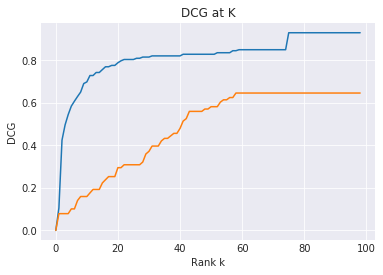

,SearchText,UserID,count
0,alwin,220403,36
1,samenloop verzekering,73363,4
2,Anglo-amerikaans recht,222150,4
3,IPR contracten,222150,4
4,wahv Betalingsregeling,99820,3
...,...,...,...
13,"liquidatieverliesregeling tussenhoudster ""ne b...",97408,1
14,HR 9 december 2011 7:2 BW,154381,1
15,rb 11 juli 2007 ja 2007 145,196134,1
16,roquette frères,546,1


In [93]:
def main() -> pd.DataFrame:
    """
    Start the workflow:
    1. Download the required dataframe, aggregated the proper clicks together calculate a dcg score 
    Return DataFrame
    """
    
    df_27 = get_dataframe_27(rows=100000000, from_disk=True)
    df_232 = get_dataframe_232(rows=1000, from_disk=False)


    df = check_and_concat(df_232=df_232, df_27=df_27)
    
    # Cast documentids to a length
    df['DocumentIDLength'] = df['DocumentIDs'].str.split().str.len()

    
    # Remove clicks where nans were added
    df['ClickedPos'] = df['ClickedPos'].progress_apply(lambda x: [y for y in x if not np.isnan(y)])
    df['ClickedPos'] = df['ClickedPos'].progress_apply(lambda x: [int(click) for click in x if not np.isnan(click)])

    df = df[df['ClickedPos'].str.len() > 1]
    
    display(df)
    

    predictions = make_predictions(df)
    
    df_2 = pd.DataFrame({'ClickedPos' : [np.random.randint(low=1,high=60, size=3) for i in range(1,17)]})
    predictions_2 = make_predictions(df_2)

    df_3 = df[df['SearchText'].split().len()]
    predictions_2 = make_predictions(df_2)
    
    
#     display(predictions)
#     display(predictions_2)

    average_at_k =  calculate_ndcg(predictions, 100)
    average_at_k_2 =  calculate_ndcg(predictions_2, 100)

    
    plt.plot(average_at_k, label= 'blueline')
    plt.plot(average_at_k_2)

    plt.xlabel('Rank k')
    plt.ylabel('DCG')
    plt.title("DCG at K")
    
    plt.show()
    
    return df


df =  main()



counter = df.groupby(['SearchText','UserID']).size().sort_values(ascending=False).reset_index(name='count')
counter

# df.progress_apply(lambda x: [{POS :  ID} for POS,ID in zip(x['DocumentID'],x['DocumentPosition'])], axis=1).tolist()

In [52]:
df_27 = get_dataframe_27(rows=100000000, from_disk=True)

# 	220403	29	2019	1639279595572166656	alwin	

df_27 = df_27[(df_27['UserID'] == 220403)  &  (df_27['ShortTimeStamp'] == 20190717) & (df_27['SearchText'] == 'alwin')]
df_27


,AppID,CompID,Department,DocumentID,DocumentPosition,DocumentSource,DocumentURL,EventID,FunctionArea,ID,Month,Publisher,Quarter,RunID,SearchText,SearchTypeID,ShortTimeStamp,SiteID,TimeStamp,UserID,Week,Year,_version_
496265,1,1220,Team Handel,28062739,75.0,OR Updates,http://www.or-updates.nl/samenvatting/OR_2018_...,27,NaN,fba98c28-f9c3-4095-9e67-b1e56e00b6b8,7,BJu,3,a8508f8d-18dc-43aa-a29a-003f7afc0f0b,alwin,14.0,20190717,1,2019-07-17T04:49:54.347Z,220403,29,2019,1639279756592545792
499800,1,1220,Team Handel,32244970,2.0,Rechtspraak.nl,http://deeplink.rechtspraak.nl/uitspraak?id=EC...,27,NaN,69f48a0f-215c-40dc-8de8-d789b7c7fd00,7,Diversen,3,5b850fb9-982a-4678-9c0c-e2a1d7745794,alwin,14.0,20190717,1,2019-07-17T04:44:38.250Z,220403,29,2019,1639279448720146432


In [94]:
import json
import urllib

# df = get_dataframe_232(rows=100000000, from_disk=True)


def query_replication(df: pd.DataFrame, i = 10):
    """
    Helper function to replicate queries
    :param df: dataframe containing a ResponseHeader from solr
    """
    
    df = df.iloc[i]

    # df['ResponseHeader']
    x = json.loads(df['ResponseHeader'])
#     x = x['params']

    x
    # Comment out to not display the original response
#     display(x)

    new_query = []
    for key,value in x.items():
        if key == 'fq':
            for fq_value in value:
                fq_value = urllib.parse.quote(string=str(fq_value))
                new_query.append("&{}={}".format('fq',fq_value))

        elif key == 'shards':
            value = value.replace("PRD_","ACC_")
            value = urllib.parse.quote(string=str(value))
            new_query.append("&{}={}".format(key,value))
        elif key == 'json.facet':
            pass
        else:
            value = urllib.parse.quote(string=str(value))
            new_query.append("&{}={}".format(key,value))

    
    params = ''.join(new_query)

    # Comment out to not display the newly made query
#     display(new_query)
    
    directory = "./curl/"

    if not os.path.exists(directory):
        os.makedirs(directory)
    

    pathlib.Path(directory  + 'params.txt').write_text(params)

    data = open(directory + 'params.txt' , 'rb').read()
    response = requests.post('http://ec2-3-120-229-133.eu-central-1.compute.amazonaws.com:8080/solr/ACC_Legal_Slave/select', data=data)
    
#     display(response)
    response = response.json()
    pathlib.Path(directory  + 'response.json').write_text(response)

#     display(response)

    
    
query_replication(df)
    
    
# curl -X POST -H 'Content-type: application/json' --data '{"text":"Hello, World!"}' https://hooks.slack.com/services/asdfasdfasdf


# headers = {
#     'Content-type': 'application/json',
# }

# data = '{"text":"Hello, World!"}'

# response = requests.post('https://hooks.slack.com/services/asdfasdfasdf', headers=headers, data=data)

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [44]:
"""
Helper function to replicate queries
:param df: dataframe containing a ResponseHeader from solr
"""

df_2 = df.iloc[2]

# df['ResponseHeader']
x = json.loads(df_2['ResponseHeader'])
#     x = x['params']

x
# Comment out to not display the original response
    display(x)

new_query = []
for key,value in x.items():
    if key == 'fq':
        for fq_value in value:
            fq_value = urllib.parse.quote(string=str(fq_value))
            new_query.append("&{}={}".format('fq',fq_value))

    elif key == 'shards':
        value = value.replace("PRD_","ACC_")
        value = urllib.parse.quote(string=str(value))
        new_query.append("&{}={}".format(key,value))
    elif key == 'json.facet':
        pass
    else:
        value = urllib.parse.quote(string=str(value))
        new_query.append("&{}={}".format(key,value))


params = ''.join(new_query)

# Comment out to not display the newly made query
#     display(new_query)

directory = "./curl/"

if not os.path.exists(directory):
    os.makedirs(directory)


pathlib.Path(directory  + 'params.txt').write_text(params)

data = open(directory + 'params.txt' , 'rb').read()
response = requests.post('http://ec2-3-120-229-133.eu-central-1.compute.amazonaws.com:8080/solr/ACC_Legal_Slave/select', data=data)

#     display(response)
response = response.json()
pathlib.Path(directory  + 'response.json').write_text(response)

#     display(response)

response    
    
    

SyntaxError: invalid syntax (<ipython-input-44-bccf0f68ea71>, line 13)

In [38]:
response = response.json
response

# Filteren op welke parameters ?
# Waar staan documentIDs
# Kunnen we dit langer in memory houden, we willen zo veel mogelijkheid query - resultaat  - click kopppels?
# Ipv delphi ->  zoveel mogelijk queries relevancy
# 

AttributeError: 'function' object has no attribute 'json'

In [41]:

df = pd.DataFrame({'A' : [1,2,3], 'B' : [3,4,1]})
df

for row in 

# for column in df:
#     print(df[column])

,A,B
0,1,3
1,2,4
2,3,1


(0, A    1
 B    3
 Name: 0, dtype: int64)

(1, A    2
 B    4
 Name: 1, dtype: int64)

(2, A    3
 B    1
 Name: 2, dtype: int64)

In [13]:
df_27 = get_dataframe_27(rows=100000000, from_disk=True)
df_232 = get_dataframe_232(rows=1000, from_disk=True)


df_27 = df_27[((df_27['UserID'] == 196134) & (df_27['SearchText'] == 'rb 11 juli 2007 ja 2007 145'))]
df_232= df_232[16:19]

In [15]:
df_232['TimeStamp'].iloc[0]
df_27['TimeStamp'].iloc[0]
time_stamp_232 = parser.parse(df_232['TimeStamp'].iloc[0], fuzzy_with_tokens=False)
timestamps_27 = parser.parse(df_27['TimeStamp'].iloc[0], fuzzy_with_tokens=False)    

print(timestamps_27 in DateTimeRange(time_stamp_232, time_stamp_232 + timedelta(minutes=5)))
    

'2019-07-17T00:15:05.395Z'

'2019-07-17T00:18:55.601Z'

True


In [32]:
for i in [1,2]:
    i

1

2

In [54]:
doc_pos = []
doc_ids = []

doc_pos.append([3])

doc_pos


[[3]]

AppID                                    1
CompID                                 562
Department                             NaN
DocumentIDs      3978023 17704600 12731504
EventID                                232
                          ...             
UserID                              196134
Week                                    29
Year                                  2019
_version_              1639262584564613120
SearchText     rb 11 juli 2007 ja 2007 145
Name: 18, Length: 19, dtype: object